In [2]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import dask
import dask.dataframe as ddf
import sys
import numpy as np

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [4]:
signal_df = pd.read_parquet("train/data/signal_data.parquet")

In [2]:
signal_df

NameError: name 'signal_df' is not defined

In [5]:
background_df = pd.read_parquet("train/data/background_data.parquet")#.compute(scheduler='threads')

In [6]:
def extract(dframe, key):
    return dframe[0][key]

In [7]:
signal_fatjets = signal_df['FatJets']
background_fatjets = background_df['FatJets']

In [8]:
keys = list(signal_fatjets[0][0].keys())

In [9]:
signal_key_vals = {}
for i in keys:
    signal_key_vals[i] = signal_fatjets.apply(lambda x: extract(x, i)).values.tolist()

In [10]:
background_key_vals = {}
for i in keys:
    background_key_vals[i] = background_fatjets.apply(lambda x: extract(x, i)).values.tolist()

In [233]:
step_sig = pd.DataFrame.from_dict(signal_key_vals)
step_bkg = pd.DataFrame.from_dict(background_key_vals)

In [234]:
items = ['area', 'eta', 'mass','msoftdrop', 'n2b1', 'n3b1', 'phi', 'pt']

In [235]:
items2 = ['msoftdrop', 'pt']

In [249]:
small_sig = step_sig[items]
small_bkg = step_bkg[items]

In [250]:
small_sig['isSignal'] = np.ones(len(small_sig))

/tmp/ipykernel_99/1762296698.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_sig['isSignal'] = np.ones(len(small_sig))


In [251]:
small_bkg['isSignal'] = np.zeros(len(small_bkg))

/tmp/ipykernel_99/773803344.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_bkg['isSignal'] = np.zeros(len(small_bkg))


In [252]:
NDIM = len(items)
df_all = pd.concat([small_sig, small_bkg])
dataset = df_all.values
X = dataset[:, 0:NDIM]
Y = dataset[:, NDIM]

In [253]:
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=7)
print(X_train_val)
print(X)

scaler = StandardScaler().fit(X_train_val)
X_train_val = scaler.transform(X_train_val)
X_test = scaler.transform(X_test)

# Split again, this time into training and validation data.
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train_val, Y_train_val, test_size=0.2, random_state=7
)


[[ 2.02539062e+00  6.09497070e-01  3.34375000e+01 ... -1.00000000e+00
  -5.65063477e-01  3.88000000e+02]
 [ 2.29296875e+00 -5.44311523e-01  1.37875000e+02 ...  1.36718750e+00
   2.70800781e+00  3.81750000e+02]
 [ 2.01367188e+00 -2.09130859e+00  9.99375000e+01 ...  1.41113281e+00
  -2.63427734e+00  2.98000000e+02]
 ...
 [ 2.01367188e+00  7.98339844e-01  7.83750000e+01 ...  1.63964844e+00
   1.15502930e+00  5.56000000e+02]
 [ 2.04492188e+00  1.16235352e+00  4.86562500e+01 ...  1.32128906e+00
  -2.17480469e+00  4.50250000e+02]
 [ 2.00390625e+00  1.52685547e+00  5.33125000e+01 ...  5.68359375e-01
  -1.89160156e+00  4.78000000e+02]]
[[ 1.97460938e+00  9.93041992e-01  8.24375000e+01 ...  1.86328125e+00
  -1.00854492e+00  3.00000000e+02]
 [ 2.04492188e+00  1.22390747e-01  9.91875000e+01 ... -1.00000000e+00
   3.13427734e+00  2.53750000e+02]
 [ 2.05468750e+00 -8.69506836e-01  6.48750000e+01 ...  1.67187500e+00
   1.93554688e+00  3.37500000e+02]
 ...
 [ 1.97460938e+00  1.62500000e+00  3.2968750

In [258]:
# Build our model.
import torch

class NeuralNetwork(nn.Module):
    def __init__(self, width=64):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(8, width),
            nn.ReLU(),
            nn.Linear(width, width),
            nn.ReLU(),
            nn.Linear(width, 1)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits
    
model = NeuralNetwork()

# Use Binary Cross Entropy as our loss function.
loss_fn = torch.nn.BCEWithLogitsLoss()

# Optimize the model parameters using the Adam optimizer.
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [259]:
# Get validation data ready
val_data = torch.from_numpy(X_val).float()
val_label = torch.from_numpy(Y_val).float()

In [260]:
from tqdm import tqdm  # for progress bar while training

losses, val_losses = [], []
min_loss, stale_epochs = 100.0, 0

# 500 epochs.
batch_size = 1024
for t in tqdm(range(60)):
    batch_loss, val_batch_loss = [], []

    for b in range(0, X_train.shape[0], batch_size):
        X_batch = X_train[b : b + batch_size]
        Y_batch = Y_train[b : b + batch_size]
        x = torch.from_numpy(X_batch).float()
        y_b = torch.from_numpy(Y_batch).float()
        y_b = y_b.view(-1, 1)

        y_pred = model(x)


        # Compute and print loss.
        loss = loss_fn(y_pred, y_b)
        batch_loss.append(loss.item())

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        with torch.inference_mode():

            output = model(val_data)

            val_y = val_label.view_as(output)
            val_loss = loss_fn(output, val_y)
            val_batch_loss.append(val_loss.item())

            # Monitor the loss function to prevent overtraining.
            if stale_epochs > 20:
                break

            if val_loss.item() - min_loss < 0:
                min_loss = val_loss.item()
                stale_epochs = 0
                #torch.save(model.state_dict(), "pytorch_model_best.pth")
            else:
                stale_epochs += 1

    losses.append(np.mean(batch_loss))
    val_losses.append(np.mean(val_batch_loss))

100%|██████████| 60/60 [00:01<00:00, 37.68it/s]


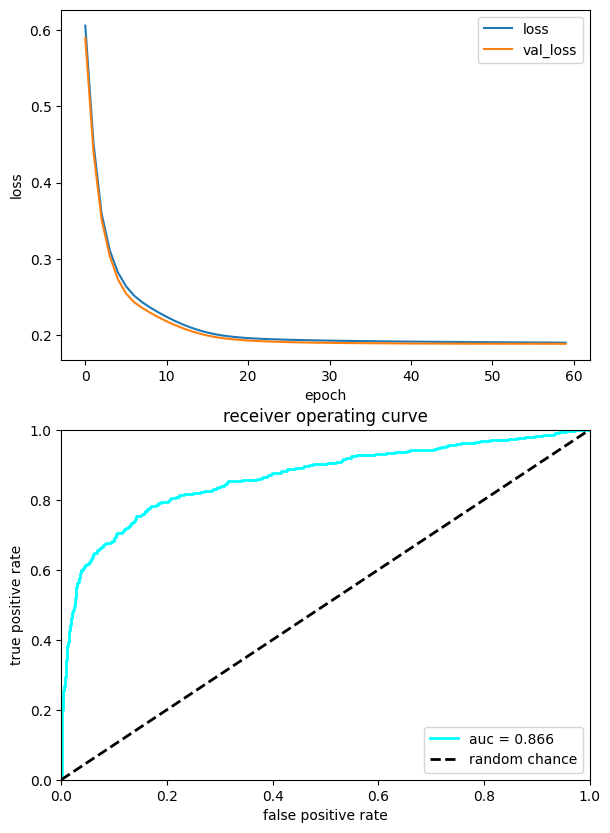

In [261]:
import matplotlib.pyplot as plt

%matplotlib inline

with torch.no_grad():
    # plot loss vs epoch
    plt.figure(figsize=(15, 10))
    ax = plt.subplot(2, 2, 1)
    ax.plot(losses, label="loss")
    ax.plot(val_losses, label="val_loss")
    ax.legend(loc="upper right")
    ax.set_xlabel("epoch")
    ax.set_ylabel("loss")

    # Plot ROC
    X_test_in = torch.from_numpy(X_test).float()
    Y_predict = model(X_test_in)
    from sklearn.metrics import roc_curve, auc

    fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
    roc_auc = auc(fpr, tpr)
    ax = plt.subplot(2, 2, 3)
    ax.plot(fpr, tpr, lw=2, color="cyan", label="auc = %.3f" % (roc_auc))
    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="k", label="random chance")
    ax.set_xlim([0, 1.0])
    ax.set_ylim([0, 1.0])
    ax.set_xlabel("false positive rate")
    ax.set_ylabel("true positive rate")
    ax.set_title("receiver operating curve")
    ax.legend(loc="lower right")
    plt.show()